In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
#generate the sample
def gen_data():
    nobs = 5000
    beta = 3
    x = np.random.uniform(low=-3., high=3., size=nobs)
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1*(1 + beta * x + e >= 0) 
    return y,x,nobs

[1.94621381 5.72114254]


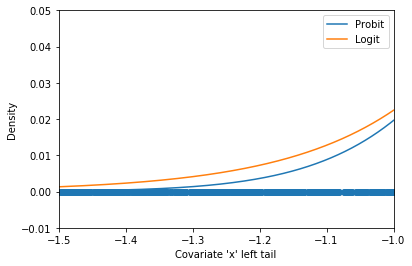

In [10]:
yn,xn, nobs = gen_data()
support = np.arange(-3,3,1/nobs)
model1 = sm.Probit(yn,sm.add_constant(xn))
model1 = model1.fit(disp=False)
model1_fit =  norm.cdf(model1.params[0] + model1.params[1]*support)

model2 = sm.Logit(yn,sm.add_constant(xn))
model2 = model2.fit(disp=False)
logit = lambda x: np.exp(x)/(1+np.exp(x))
model2_fit = logit(model2.params[0] + model2.params[1]*support)

print(model2.params)

plt.scatter(xn,yn)
plt.plot(support,model1_fit,label="Probit")
plt.plot(support,model2_fit,label="Logit")
plt.legend()
plt.xlim((-1.5,-1))
plt.ylim((-.01,.05))
plt.ylabel("Density")
plt.xlabel("Covariate 'x' left tail")
plt.savefig('figs/form_fit1')
plt.show()

In [12]:
#visualize the guassian process
def gen_llr():
    y,x,N = gen_data()
    ll1 = []
    ll2 = []
    omegas = []
    n0 = 2000
    skip = 500

    for n in range(n0,N,skip):
        xn = x[1:n+1]
        yn = y[1:n+1]
    
        model1 = sm.Probit(yn,sm.add_constant(xn))
        model1_fit = model1.fit(disp=False)
        pr1 = model1.loglikeobs(model1_fit.params)
    
        model2 = sm.Logit(yn,sm.add_constant(xn),sim_function=np.random.normal)
        model2_fit = model2.fit(disp=False)
        pr2 = model2.loglikeobs(model2_fit.params)
    
        omega = (pr1- pr2).var()
        
        ll1.append(pr1.sum())
        ll2.append(pr2.sum())
        omegas.append(omega)
   
    return ll1, ll2, omegas, n0, N, skip


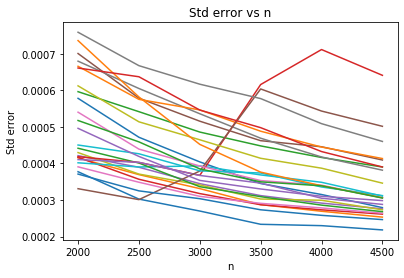

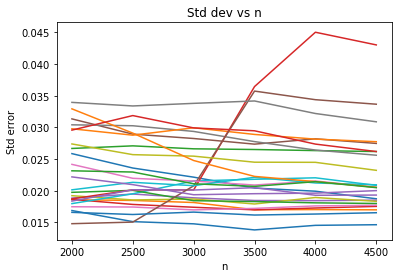

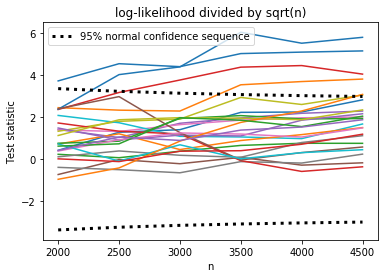

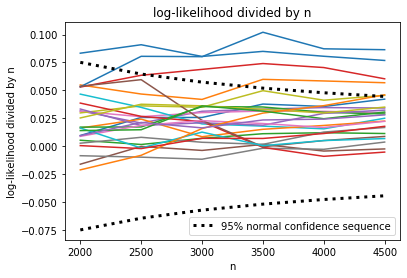

In [13]:
trials = 25
for i in range(trials):
    ll1, ll2, sample_var, n0, N, skip = gen_llr()
    scale = np.arange(n0,N,skip)
    
    std_dev = np.sqrt(np.array(sample_var))
    std_error = std_dev/np.sqrt(scale)
    process =  (np.array(ll1) - np.array(ll2))
    
    
    #std error
    plt.figure(1)
    plt.plot(scale, std_error )
    
    #std dev
    plt.figure(2)
    plt.plot(scale, std_dev )

    #scale by std error (convergence in distribution)
    plt.figure(3)
    plt.plot(scale,  process/(std_error*scale))
    
    
    #scale by n (convergence in probability)
    plt.figure(4)
    plt.plot(scale,  process/(std_dev*scale))
    

#plot 1
plt.figure(1)
plt.title("Std error vs n")
plt.ylabel("Std error")
plt.xlabel("n")
plt.savefig("figs/std_error")

#plot 2
plt.figure(2)
plt.title("Std dev vs n")
plt.ylabel("Std error")
plt.xlabel("n")
plt.savefig("figs/std_dev")

#plot 3
plt.figure(3)
plt.title("log-likelihood divided by sqrt(n)")
plt.ylabel("Test statistic")
plt.xlabel("n")
conf_seq = np.sqrt((scale+n0)*(6 + np.log(np.log(scale/n0+1)))/scale)
plt.plot(scale, conf_seq,  color='black', linewidth=3, linestyle=":",
         label="95% normal confidence sequence" )
plt.plot(scale, -conf_seq,  color='black', linewidth=3, linestyle=":")

#critical values (usual)
if False:
    conf_int = 1.96*np.ones(scale.shape[0])
    plt.plot(scale, conf_int ,  color='black', linewidth=3, linestyle="--",  
         label="95% normal confidence interval" )
    plt.plot(scale,-conf_int, color='black', linewidth=3, linestyle="--")


plt.legend()

plt.savefig("figs/ll_rootn")


#plot 4
plt.figure(4)
plt.title("log-likelihood divided by n")
plt.ylabel("log-likelihood divided by n")
plt.xlabel("n")

plt.plot(scale, conf_seq/np.sqrt(scale),  color='black', linewidth=3, linestyle=":",
         label="95% normal confidence sequence" )
plt.plot(scale, -conf_seq/np.sqrt(scale),  color='black', linewidth=3, linestyle=":")

#critical values (usual)
if False:
    plt.plot(scale, conf_int/np.sqrt(scale) ,  color='black', linewidth=3, linestyle="--",  
         label="95% normal confidence interval" )
    plt.plot(scale,-conf_int/np.sqrt(scale), color='black', linewidth=3, linestyle="--")

plt.legend()

plt.savefig("figs/ll_n")

In [17]:
reject_usual = 0
reject_seq = 0
trials = 1000
for i in range(trials):
    try:
        ll1, ll2, sample_var, n0, N, skip = gen_llr()
        scale = np.arange(n0,N,skip)

        std_dev = np.sqrt(np.array(sample_var))
        std_error = std_dev/np.sqrt(scale)
        process =  (np.array(ll1) - np.array(ll2))

        test_stat = np.abs(process)/(std_error*scale)
        if (test_stat >= conf_seq).max() :
            reject_seq = reject_seq+1

        if (test_stat[-1] >= 1.96):
            reject_usual = reject_usual +1
    except:
        pass
    
print("usual test: %s, sequence: %s"%(reject_usual/trials, reject_seq/trials))

usual test: 0.321, sequence: 0.219
